# Image Augmentation

In [1]:
from pathlib import Path

BASE_DIR = Path('/Users/efraflores/Desktop/hub/datathon2021/Scripts/data/test')

## Import image

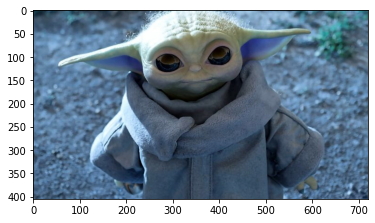

In [2]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread(str(BASE_DIR.joinpath('Grogu.jpeg')))
plt.imshow(image)
plt.show()

## Correct cv2 color

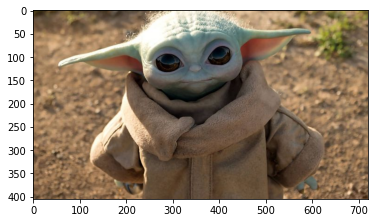

In [3]:
# Needs to correct the color with the next line
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

## Augmentations

In [4]:
import albumentations as A

In [5]:
def show_image(effects, img=image):
    augmented = A.Compose([eval(effects),])(image=img)['image']
    # It returns a modified array, to display it, the following lines
    plt.imshow(augmented)
    plt.title(effects)
    plt.show()

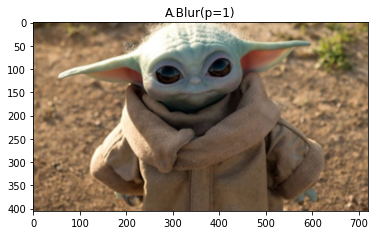

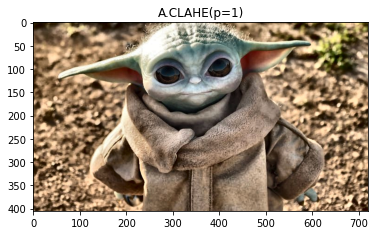

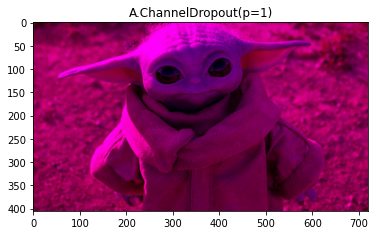

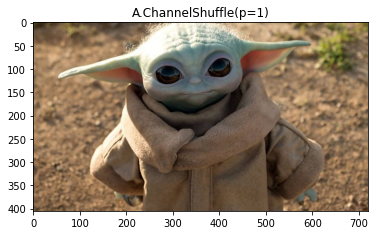

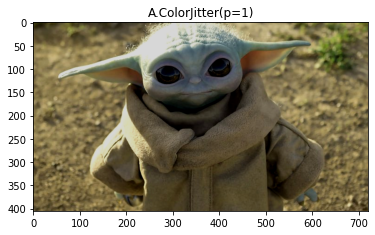

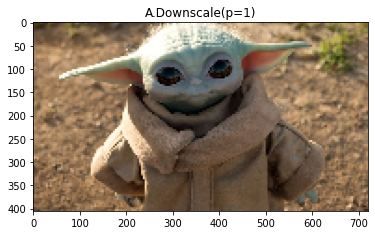

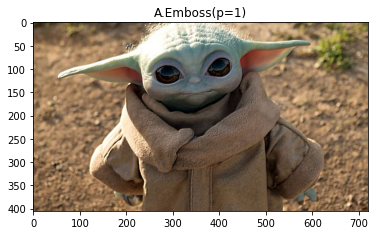

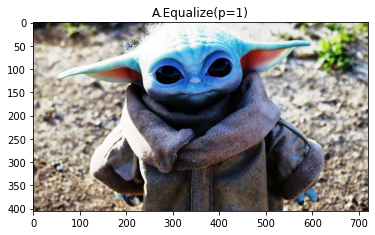

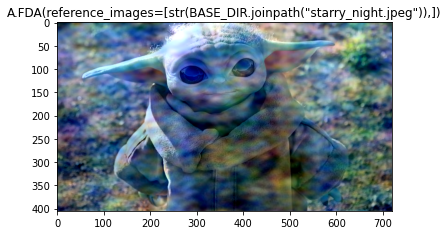

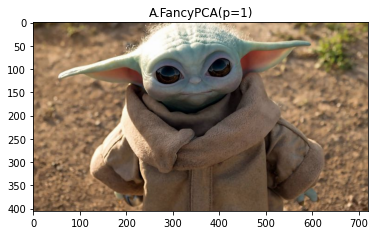

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


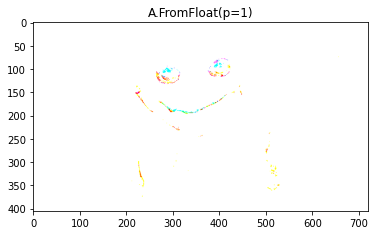

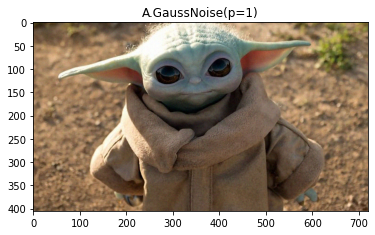

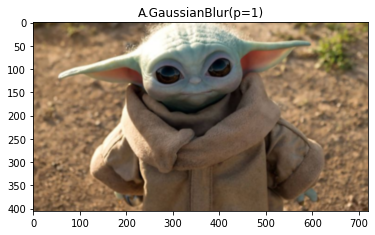

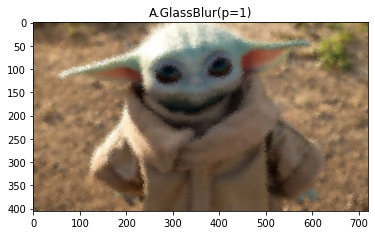

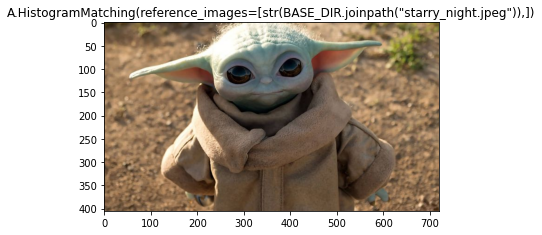

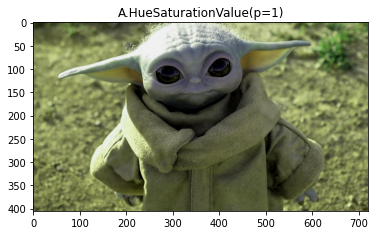

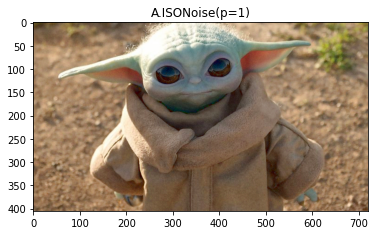

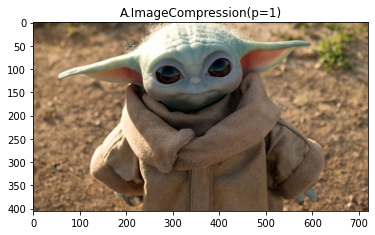

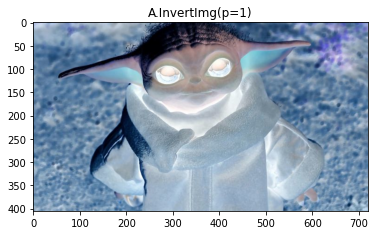

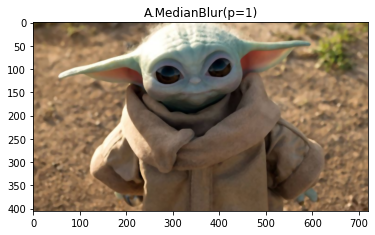

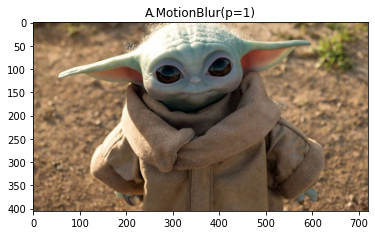

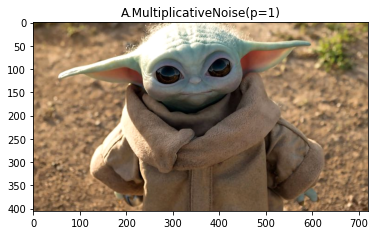

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


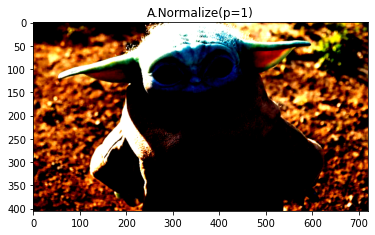

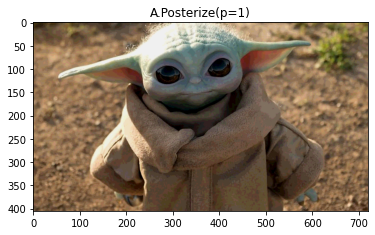

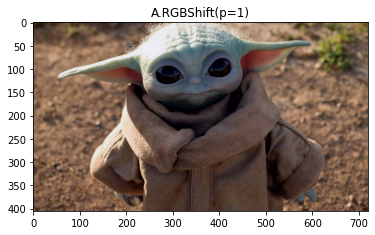

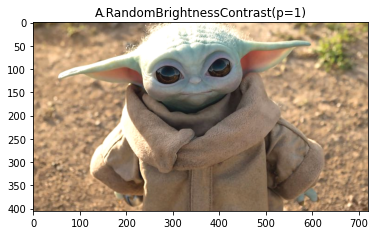

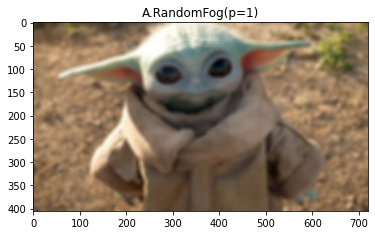

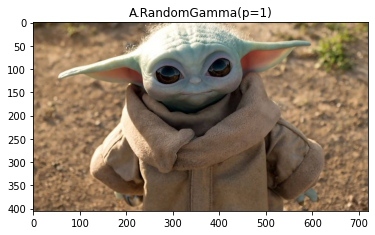

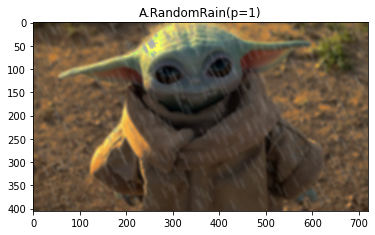

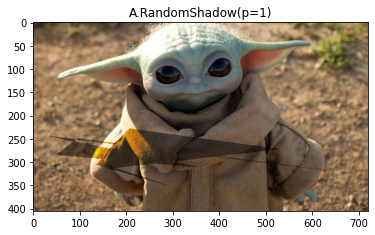

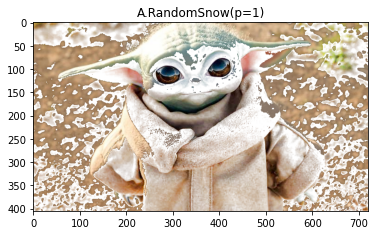

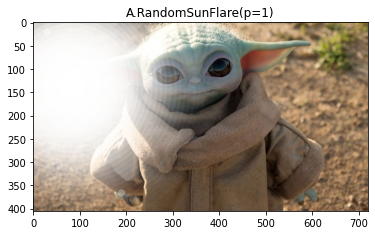

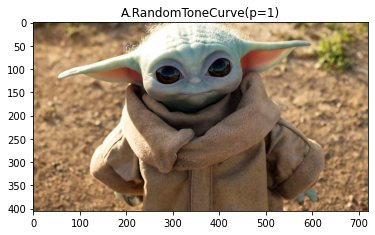

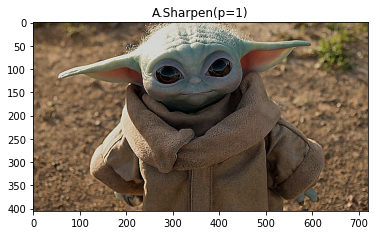

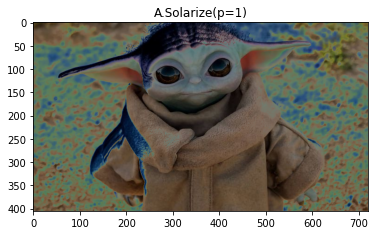

/Users/efraflores/Desktop/hub/datathon2021/venv/lib/python3.9/site-packages/albumentations/augmentations/functional.py:1752: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = skimage.segmentation.slic(image, n_segments=n_segments, compactness=10)


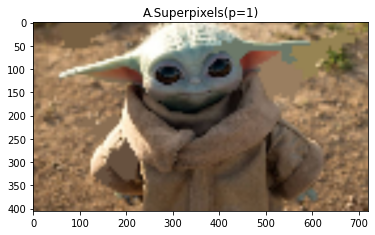

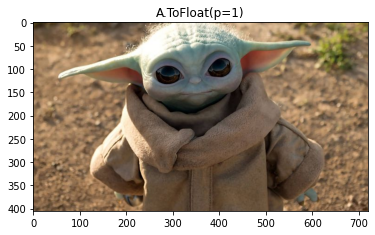

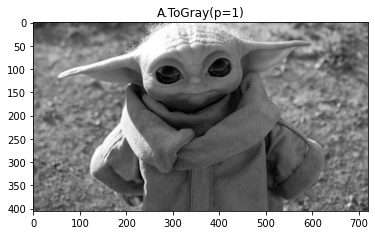

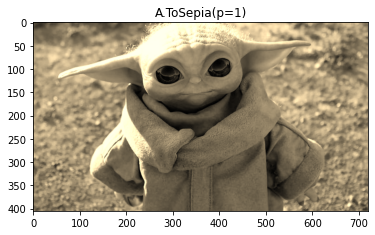

In [6]:
for x in ['A.Blur(p=1)',
    'A.CLAHE(p=1)',
    'A.ChannelDropout(p=1)',
    'A.ChannelShuffle(p=1)',
    'A.ColorJitter(p=1)',
    'A.Downscale(p=1)',
    'A.Emboss(p=1)',
    'A.Equalize(p=1)',
    'A.FDA(reference_images=[str(BASE_DIR.joinpath("starry_night.jpeg")),])',
    'A.FancyPCA(p=1)',
    'A.FromFloat(p=1)',
    'A.GaussNoise(p=1)',
    'A.GaussianBlur(p=1)',
    'A.GlassBlur(p=1)',
    'A.HistogramMatching(reference_images=[str(BASE_DIR.joinpath("starry_night.jpeg")),])',
    'A.HueSaturationValue(p=1)',
    'A.ISONoise(p=1)',
    'A.ImageCompression(p=1)',
    'A.InvertImg(p=1)',
    'A.MedianBlur(p=1)',
    'A.MotionBlur(p=1)',
    'A.MultiplicativeNoise(p=1)',
    'A.Normalize(p=1)',
    'A.Posterize(p=1)',
    'A.RGBShift(p=1)',
    'A.RandomBrightnessContrast(p=1)',
    'A.RandomFog(p=1)',
    'A.RandomGamma(p=1)',
    'A.RandomRain(p=1)',
    'A.RandomShadow(p=1)',
    'A.RandomSnow(p=1)',
    'A.RandomSunFlare(p=1)',
    'A.RandomToneCurve(p=1)',
    'A.Sharpen(p=1)',
    'A.Solarize(p=1)',
    'A.Superpixels(p=1)',
    'A.ToFloat(p=1)',
    'A.ToGray(p=1)',
    'A.ToSepia(p=1)',]: show_image(x)

## Add to Keras ImageDataGenerator

In [7]:
import albumentations as A
import numpy as np
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence

df = pd.read_csv(BASE_DIR.joinpath('leaf_train.csv')).sample(frac=0.01)
df['label'] = df['label'].astype(str)
print(df.head())

             image_id label
2051   1358076537.jpg     0
12129  3171661108.jpg     3
4454    179556493.jpg     2
3916   1696821568.jpg     3
18602   479283253.jpg     3


In [8]:
IMAGES_DIR = '/Users/efraflores/Downloads/leaf_train_img'

To download the images go to <https://www.kaggle.com/c/cassava-leaf-disease-classification/data?select=train_images>

In [9]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

model = Sequential([
    EfficientNetB0(include_top=False),
    GlobalAveragePooling2D(),
    Dense(5, activation='softmax'),
])
model.compile('adam', 'categorical_crossentropy', ['accuracy'])

class AugmentDataGenerator(Sequence):
    def __init__(self, datagen, augment=None):
        self.datagen = datagen
        if augment is None:
            self.augment = A.Compose([])
        else:
            self.augment = augment

    def __len__(self):
        return len(self.datagen)

    def __getitem__(self, x):
        images, *rest = self.datagen[x]
        augmented = []
        for image in images:
            image = self.augment(image=image)['image']
            augmented.append(image)
        return (np.array(augmented), *rest)


datagen = ImageDataGenerator()\
    .flow_from_dataframe(
        dataframe=df,
        directory=IMAGES_DIR,
        x_col='image_id',
        y_col='label',
        target_size=(600, 800),
    )

datagen = AugmentDataGenerator(datagen, A.Compose([
    A.RandomResizedCrop(256, 256),
    A.Flip(),
    A.Rotate(),
    A.Sharpen(p=1),
]))

model.fit(datagen, epochs=3, batch_size=64, workers=8)

Found 214 validated image filenames belonging to 5 classes.
Epoch 1/3
7/7 [==============================] - 49s 6s/step - loss: 1.2024 - accuracy: 0.5748
Epoch 2/3
7/7 [==============================] - 39s 6s/step - loss: 0.7665 - accuracy: 0.7196
Epoch 3/3
7/7 [==============================] - 63s 9s/step - loss: 0.5663 - accuracy: 0.8224
